# Introduction

This is a map-reduce version of expectation maximization algo for a mixture of Gaussians model. There are two mrJob MR packages, mr_GMixEmIterate and mr_GMixEmInitialize.  The driver calls the mrJob packages and manages the iteration. 

## Expectation Step: Given priors, mean vector and covariance matrix, calculate the probability that each data point belongs to a class 

**Equation(1)**

$\huge p(\omega_k | x^{(i)},\theta) = \frac{\pi_k N(x^{(i)} | \mu_k,\Sigma_k)}{\Sigma_{j=1}^{K}\pi_j N(x^{(i)}| \mu_j,\Sigma_j)}$


**where $\theta$ comprises of the parameters of our Gaussian Model $\mu_k$ (mean vector) and $\Sigma_k$ (Covariance Matrix)**

**where $\omega_k$ is the cluster k**

**$x^{(i)}$ is the data at the $i^{th}$ row**

**$N(x^{(i)} | \mu_k,\Sigma_k)$ gives the probability density from a multivariate normal distribution with mean vector of $\mu_k$ and covariance matrix of $\Sigma_k$ associated with the data point $x^{(i)}$**


## Maximization Step: Given probabilities, update priors, mean and covariance

**Equation(2)**

$$\large \hat\mu_{k} = \frac{1}{n_k}\sum_{i=1}^{n} p(\omega_k|x^{(i)},\theta)x^{(i)}$$ 

where $\large \hat\mu_k{k}$ is the estimated mean vector for cluster k 


**Equation(3)**

$$\large \hat\Sigma_{k} = \frac{1}{n_k}\sum_{i=1}^{n} p(\omega_k|x^{(i)},\theta)(x^{(i)} - \hat\mu_k)(x^{(i)}- \hat\mu_k)^T$$ 

where $\hat\Sigma_{k}$ is the estimated covariance matrix for cluster k 
where $p(\omega_k|x^{(i)},\theta)$ is the estimated probability for a cluster,k to have a data point $x^{i}$ 

**Equation(4)**

$$\large \hat\pi_{k} = \frac{n_k}{n} where \ n_k = \sum_{i=1}^{n} p(\omega_k|x^{(i)},\theta)$$

where $\hat\pi_{k}$ is the estimated prior for cluster k.

# Data Generation

In [77]:
 %matplotlib inline
import numpy as np
import pylab 
import json

#Generating three clusters of data with different means and same covariance matrices
size1 = size2 = size3 = 1000
samples1 = np.random.multivariate_normal([4, 0], [[1, 0],[0, 1]], size1)
data = samples1
samples2 = np.random.multivariate_normal([6, 6], [[1, 0],[0, 1]], size2)
data = np.append(data,samples2, axis=0)
samples3 = np.random.multivariate_normal([0, 4], [[1, 0],[0, 1]], size3)
data = np.append(data,samples3, axis=0)

#Printing the shape of the data
print "Shape of the data is..",data.shape

#Printing the data
print "\n Data is..\n",data

# Randomize data
data = data[np.random.permutation(size1+size2+size3),]
with open("data.txt", "w") as f:
    for row in data.tolist():
        json.dump(row, f)
        f.write("\n")

Shape of the data is.. (3000, 2)

 Data is..
[[ 4.05709533 -0.62339635]
 [ 2.90284724  0.50919909]
 [ 1.90055869 -1.37698991]
 ..., 
 [ 1.23723036  3.97791296]
 [-0.29637591  2.71592457]
 [ 0.82730457  2.59897586]]


# Data Visualization

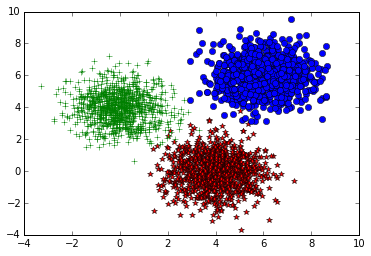

In [78]:
pylab.plot(samples1[:, 0], samples1[:, 1],'*', color = 'red')
pylab.plot(samples2[:, 0], samples2[:, 1],'o',color = 'blue')
pylab.plot(samples3[:, 0], samples3[:, 1],'+',color = 'green')
pylab.show()

# Initialization

The priors, mean vector and the covariance matrices are initialized in this code section.

We have a Gaussian Mixture Model with 3 components.

In the initialization all the 3 components are given equal priors of 1/3

The starting mean vector is the 3 sampled rows from the first 6 rows of the shuffled data.

The starting covariance vector is then computed from the 3 sampled rows and the mean vector.

In [79]:
%%writefile mr_GMixEmInitialize.py
from mrjob.job import MRJob

from numpy import mat, zeros, shape, random, array, zeros_like, dot, linalg
from random import sample
import json
from math import pi, sqrt, exp, pow


class MrGMixEmInit(MRJob):
    DEFAULT_PROTOCOL = 'json'
    
    def __init__(self, *args, **kwargs):
        super(MrGMixEmInit, self).__init__(*args, **kwargs)
        
        self.numMappers = 1     #number of mappers
        self.count = 0
        
                                                 
    def configure_options(self):
        super(MrGMixEmInit, self).configure_options()
        self.add_passthrough_option(
            '--k', dest='k', default=3, type='int',
            help='k: number of densities in mixture')
        self.add_passthrough_option(
            '--pathName', dest='pathName', default="", type='str',
            help='pathName: pathname where intermediateResults.txt is stored')
        
    def mapper(self, key, xjIn):
        #something simple to grab random starting point
        #collect the first 2k
        if self.count <= 2*self.options.k:
            self.count += 1
            yield (1,xjIn)        
        
    def reducer(self, key, xjIn):        
        #accumulate data points mapped to 0 from 1st mapper and pull out k of them as starting point
        cent = []
        for xj in xjIn:
            x = json.loads(xj)
            cent.append(x)
            yield 1, xj
        index = sample(range(len(cent)), self.options.k)
        cent2 = []
        for i in index:
            cent2.append(cent[i])  #starting centroids of the 3 gaussian models in the mixture model
        
        #use the covariance of the selected centers as the starting guess for covariances
        #first, calculate mean of centers
        
        mean = array(cent2[0])
        for i in range(1,self.options.k):
            mean = mean + array(cent2[i])
        mean = mean/float(self.options.k) #mean vector to compute the covariance
        
        #then accumulate the deviations and compute the starting covariance matrix
        cov = zeros((len(mean),len(mean)),dtype=float)
        
        for x in cent2:
            xmm = array(x) - mean
            for i in range(len(mean)):
                cov[i,i] = cov[i,i] + xmm[i]*xmm[i] #starting covariance matrix
                
        cov = cov/(float(self.options.k))
        
        #Inverse of the covariance matrix to compute the probability density of a point from the normal distribution
        covInv = linalg.inv(cov)
        
        cov_1 = [covInv.tolist()]*self.options.k
        
        jDebug = json.dumps([cent2,mean.tolist(),cov.tolist(),covInv.tolist(),cov_1])    
        debugPath = self.options.pathName + 'debug.txt'
        fileOut = open(debugPath,'w')
        fileOut.write(jDebug)
        fileOut.close()
        
        #also need a starting guess at the phi's - prior probabilities
        #initialize them all with the same number - 1/k - equally probably for each cluster
        
        phi = zeros(self.options.k,dtype=float)
        
        for i in range(self.options.k):
            phi[i] = 1.0/float(self.options.k)
        
        #form output object
        outputList = [phi.tolist(), cent2, cov_1]
            
        jsonOut  = json.dumps(outputList)
        
        #write new parameters to file
        fullPath = self.options.pathName + 'intermediateResults.txt'
        fileOut = open(fullPath,'w')
        fileOut.write(jsonOut)
        fileOut.close()

if __name__ == '__main__':
    MrGMixEmInit.run()

Overwriting mr_GMixEmInitialize.py


# Iteration

**Mapper** – each mapper needs k vector means and covariance matrices to make probability calculations.  Can also accumulate partial sum (sum restricted to the mapper's input) of quantities required for update.  Then it emits partial sum as single output from combiner.  
    Emit (dummy_key, partial_sum_for_all_k's)

**Reducer** –the iterator pulls in the partial sum for all k's from all the mappers and combines in a single reducer.  In this case the reducer emits a single (json'd python object) with the new means and covariances.


In [80]:
%%writefile mr_GMixEmIterate.py
from mrjob.job import MRJob

from math import sqrt, exp, pow,pi
from numpy import zeros, shape, random, array, zeros_like, dot, linalg
import json

#Probability density of the Gaussian/Normal Distribution
def gauss(x, mu, P_1):
    xtemp = x - mu
    n = len(x)
    p = exp(- 0.5*dot(xtemp,dot(P_1,xtemp)))
    detP = 1/linalg.det(P_1)
    p = p/(pow(2.0*pi,n/2.0)*sqrt(detP))
    return p

class MrGMixEm(MRJob):
    DEFAULT_PROTOCOL = 'json'
    
    def __init__(self, *args, **kwargs):
        super(MrGMixEm, self).__init__(*args, **kwargs)
        
        fullPath = self.options.pathName + 'intermediateResults.txt'
        fileIn = open(fullPath)
        inputJson = fileIn.read()
        fileIn.close()
        inputList = json.loads(inputJson)
        temp = inputList[0]        
        self.phi = array(temp)           #prior class probabilities
        temp = inputList[1]
        self.means = array(temp)         #current means list
        temp = inputList[2]
        self.cov_1 = array(temp)         #inverse covariance matrices for w, calc.
        #accumulate partial sums                               
        #sum of weights - by cluster
        self.new_phi = zeros_like(self.phi)        #partial weighted sum of weights
        self.new_means = zeros_like(self.means)
        self.new_cov = zeros_like(self.cov_1)
        
        self.numMappers = 1             #number of mappers
        self.count = 0                  #passes through mapper
        
                                                 
    def configure_options(self):
        super(MrGMixEm, self).configure_options()

        self.add_passthrough_option(
            '--k', dest='k', default=3, type='int',
            help='k: number of densities in mixture')
        self.add_passthrough_option(
            '--pathName', dest='pathName', default="", type='str',
            help='pathName: pathname where intermediateResults.txt is stored')
        
    def mapper(self, key, val):
        #accumulate partial sums for each mapper
        xList = json.loads(val)
        x = array(xList)
        wtVect = zeros_like(self.phi)
        
        #Following loop will loop over all the three gaussian models which are part of the mixture model.
        #Each Gaussian has its own mean vector and a covariance matrix.
        #The function gauss computes the probability density for a mean vector,self.means*
        #and covariance matrix,self.cov_l* at a point x (2 dimensional in our case).
        #See equation(1)
        for i in range(self.options.k):
            wtVect[i] = self.phi[i]*gauss(x,self.means[i],self.cov_1[i])
        
        #Weights "wtVect" are computed for each of the cluster (See equation(4))
        wtSum = sum(wtVect)
        wtVect = wtVect/wtSum
        
        #accumulate to update estimate of probability densities.
        #increment count
        self.count += 1
        #accumulate weights for phi estimate
        self.new_phi = self.new_phi + wtVect
        
        for i in range(self.options.k):
            #for each cluster ,accumulate weighted x's for mean calculation (see equation(2))
            self.new_means[i] = self.new_means[i] + wtVect[i]*x
            #accumulate weighted squares for cov estimate
            xmm = x - self.means[i]
            covInc = zeros_like(self.new_cov[i])
            
            #for each cluster, accumulate the covariance matrix (see equation(3))
            for l in range(len(xmm)):
                for m in range(len(xmm)):
                    covInc[l][m] = xmm[l]*xmm[m]
            self.new_cov[i] = self.new_cov[i] + wtVect[i]*covInc     
        #dummy yield - real output passes to mapper_final in self

    def mapper_final(self):
        
        #For each data-point (in this case 2-dimensional), the following is yielded from the mapper
        # count,phi(weights),mean vector,covariance matrix
        out = [self.count, (self.new_phi).tolist(), (self.new_means).tolist(), (self.new_cov).tolist()]
        jOut = json.dumps(out)        
        
        yield 1,jOut
    
    
    #Reducers job is to accumulate the partial stats to be able to compute the mean vector,covariance matrix 
    #and the weight vector (phi)
    def reducer(self, key, xs):
        #accumulate partial sums
        first = True        
        #accumulate partial sums
        #xs gives us a list of partial stats, including count, phi, mean, and covariance. 
        #Each stat is k-length array, storing info for k components
        for val in xs:
            if first:
                temp = json.loads(val)
                #totCount, totPhi, totMeans, and totCov are all arrays
                totCount = temp[0]
                totPhi = array(temp[1])
                totMeans = array(temp[2])
                totCov = array(temp[3])                
                first = False
            else:
                temp = json.loads(val)
                #cumulative sum of four arrays
                totCount = totCount + temp[0]
                totPhi = totPhi + array(temp[1])
                totMeans = totMeans + array(temp[2])
                totCov = totCov + array(temp[3])
        #finish calculation of new probability parameters. array divided by array
        
        #New prior
        newPhi = totPhi/totCount
        
        #initialize these to something handy to get the right size arrays
        newMeans = totMeans
        newCov_1 = totCov
        
        #Computation of the new mean vector and new covariance matrix for each cluster in the mixture model
        for i in range(self.options.k):
            newMeans[i,:] = totMeans[i,:]/totPhi[i]
            tempCov = totCov[i,:,:]/totPhi[i]
            #almost done.  just need to invert the cov matrix.  invert here to save doing a matrix inversion
            #with every input data point.
            newCov_1[i,:,:] = linalg.inv(tempCov)
        
        outputList = [newPhi.tolist(), newMeans.tolist(), newCov_1.tolist()]
        jsonOut = json.dumps(outputList)
        
        #write new parameters to file
        fullPath = self.options.pathName + 'intermediateResults.txt'
        fileOut = open(fullPath,'w')
        fileOut.write(jsonOut)
        fileOut.close()

if __name__ == '__main__':
    MrGMixEm.run()

Overwriting mr_GMixEmIterate.py


# Driver

Iteration0
[[5.376251791014099, 4.0536640094068535], [-2.3698334740101132, 5.218663337995239], [4.654094129351092, 0.2996104151781737]]


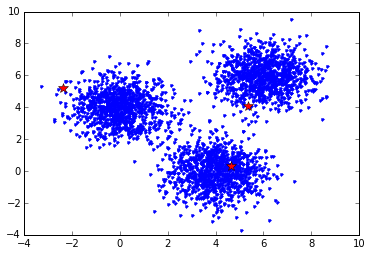

Iteration1
[[4.591461200902838, 4.9269614413882525], [0.518075632176045, 4.357816882337882], [3.6683813990702063, 0.4508494682255426]]


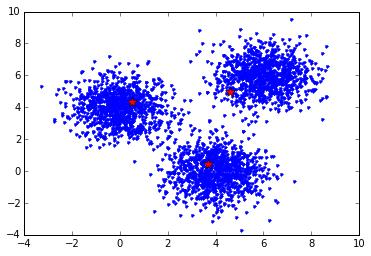

Iteration2
[[4.6587777461421105, 5.253130514451509], [0.5347534169285181, 4.195461772729766], [3.635236018758099, 0.23945927008261875]]


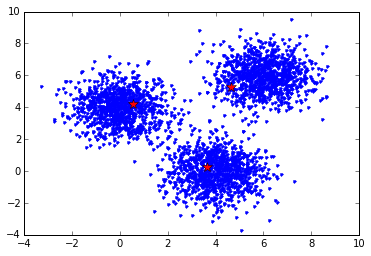

Iteration3
[[5.033418063434537, 5.553341609766534], [0.06595515220746473, 4.144106626737226], [3.827363497479539, 0.07032396079213965]]


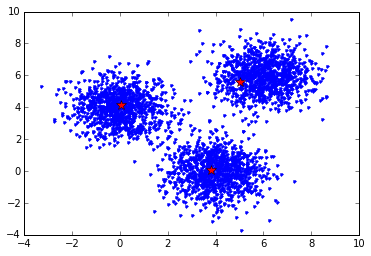

Iteration4
[[5.411262012185526, 5.722838861674466], [-0.14502377486537912, 4.045949768928088], [3.9463271127496684, -0.012021695696866112]]


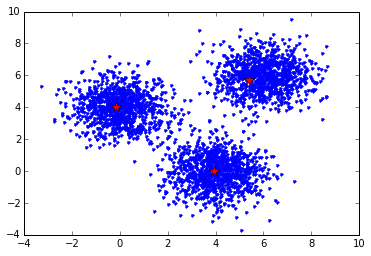

Iteration5
[[5.733961710881594, 5.85324515437197], [-0.13985725478541852, 3.9939887953878097], [3.9887856486850573, -0.040224894726614294]]


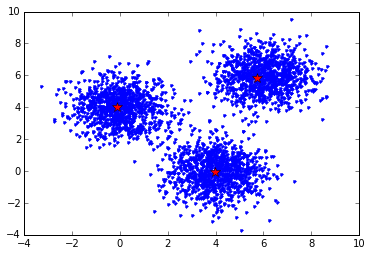

Iteration6
[[5.9167304530376414, 5.932999056318843], [-0.08322944606402453, 3.98670346729737], [3.997126867750272, -0.04118601322850161]]


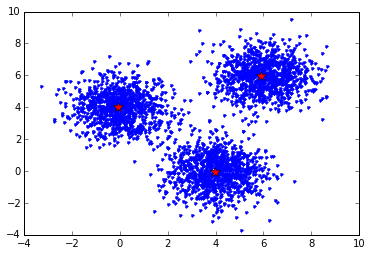

Iteration7
[[5.986718758460022, 5.970126677180979], [-0.04529627244497188, 3.9871680780237035], [4.000899162368135, -0.036498388249293086]]


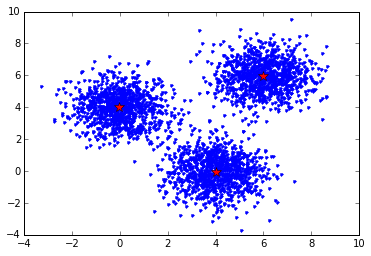

Iteration8
[[5.998343885633147, 5.979232289949936], [-0.03577192374171773, 3.9859041236063724], [4.003821387628006, -0.034516572872369575]]


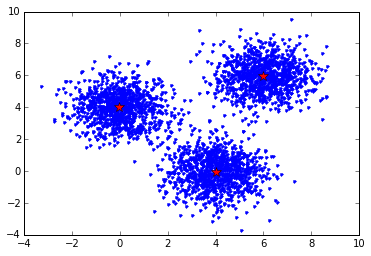

Iteration9
[[5.999728361776453, 5.980839692756419], [-0.03391519944973914, 3.9851485848864465], [4.005034408410026, -0.0343385119094878]]


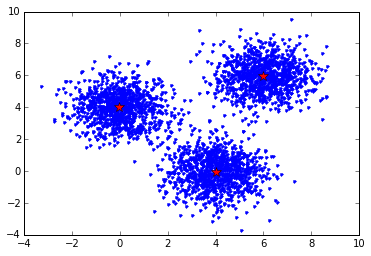

In [81]:
from mr_GMixEmInitialize import MrGMixEmInit
from mr_GMixEmIterate import MrGMixEm
import json
from math import sqrt

def plot_iteration(means):
    pylab.plot(samples1[:, 0], samples1[:, 1], '.', color = 'blue')
    pylab.plot(samples2[:, 0], samples2[:, 1], '.', color = 'blue')
    pylab.plot(samples3[:, 0], samples3[:, 1],'.', color = 'blue')
    pylab.plot(means[0][0], means[0][1],'*',markersize =10,color = 'red')
    pylab.plot(means[1][0], means[1][1],'*',markersize =10,color = 'red')
    pylab.plot(means[2][0], means[2][1],'*',markersize =10,color = 'red')
    pylab.show()

def dist(x,y):
    #euclidean distance between two lists    
    sum = 0.0
    for i in range(len(x)):
        temp = x[i] - y[i]
        sum += temp * temp
    return sqrt(sum)

#first run the initializer to get starting centroids
filePath = 'data.txt'
mrJob = MrGMixEmInit(args=[filePath,'--pathName','/Users/Vamsi/Documents/W261/hw6/'])
with mrJob.make_runner() as runner:
    runner.run()

#pull out the centroid values to compare with values after one iteration
emPath = "intermediateResults.txt"
fileIn = open(emPath)
paramJson = fileIn.read()
fileIn.close()

delta = 10
iter_num = 0
#Begin iteration on change in centroids
while delta > 0.02:
    print "Iteration" + str(iter_num)
    iter_num = iter_num + 1
    #parse old centroid values
    oldParam = json.loads(paramJson)
    #run one iteration
    oldMeans = oldParam[1]
    mrJob2 = MrGMixEm(args=[filePath,'--pathName','/Users/Vamsi/Documents/W261/hw6/'])
    with mrJob2.make_runner() as runner:
        runner.run()

    #compare new centroids to old ones
    fileIn = open(emPath)
    paramJson = fileIn.read()
    fileIn.close()
    newParam = json.loads(paramJson)

    k_means = len(newParam[1])
    newMeans = newParam[1]

    #Checking to see the euclidean distance between old and new means are greater than delta or less than delta
    #if greater than delta, then we keep run another iteration of the Expectation-Maximization algorithm
    #if less than delta, we terminate the algorithm and signal convergence.
    delta = 0.0
    for i in range(k_means):
        delta += dist(newMeans[i],oldMeans[i])

    print oldMeans
    plot_iteration(oldMeans)
print "Iteration" + str(iter_num)
print newMeans
plot_iteration(newMeans)